In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import bezier
import os

In [14]:
class airfoil_structured:
    #класс для хранения данных о профиле с структурированными точками (расстояние между всеми абсциссами одинаковое)
    def __init__(self, r_forw, up_coords, down_coords, dy_te):   
        self.N = len(up_coords) + 3
        self.r_forw = r_forw
        self.dy_te = dy_te
        self.x_coords = np.append([0], np.linspace(0, 1, self.N-1)) #вторая точка должна висеть на нуле и задавать 1) радиус кривизны 2) вертикальность касательной передней кромки 
        self.up_y_coords = np.concatenate(([0, 0], up_coords, [dy_te/2]))
        self.down_y_coords = np.concatenate(([0, 0], down_coords, [-dy_te/2]))
        D = self.x_coords[2] #там на самом деле сложная формула и с ней можно ознакомиться в папке с материалами, но она упрощается до такого вида
        t = (r_forw*D*(self.N-2)/(self.N-1))**0.5
        self.up_y_coords[1] = t
        self.down_y_coords[1] = -t
        self.update_curve()
    def update_curve(self):
        upnodes = np.asfortranarray([self.x_coords, self.up_y_coords])
        downnodes = np.asfortranarray([self.x_coords, self.down_y_coords])
        self.upcurve = bezier.Curve.from_nodes(upnodes)
        self.downcurve = bezier.Curve.from_nodes(downnodes)
    def coords(self, Ncoords):
        t_space = np.linspace(0, 1, Ncoords)
        up_coords = self.upcurve.evaluate_multi(t_space)
        down_coords = self.downcurve.evaluate_multi(t_space)
        return up_coords, down_coords
    def self_intersect(self):
        if self.dy_te != 0: intersec_num = 1
        else: intersec_num = 2
        intersections = self.upcurve.intersect(self.downcurve)
        return len(intersections[0]) > intersec_num
    def plot(self, show_circle = False):
        data = self.coords(100)
        x_coords = np.append(data[0][0], data[1][0][::-1])
        y_coords = np.append(data[0][1], data[1][1][::-1])
        plt.figure(figsize=(9, 5))
        plt.plot(x_coords, y_coords, 'b-', linewidth=2)  
        plt.title(f"Профиль по {(self.N-3)*2+1} параметрам, толщина = {round(self.thick()[0], 2)}%", fontsize=14)
        plt.xlabel("X", fontsize=12)
        plt.ylabel("Y", fontsize=12)
        plt.grid()
        plt.axis('equal')  
        plt.scatter(self.x_coords, self.up_y_coords, color = "black", s=25)
        plt.scatter(self.x_coords, self.down_y_coords, color = "black", s=25)
        plt.legend()   
        if(show_circle):
            plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)  # Горизонтальная ось
            plt.gca().add_artist(plt.Circle((self.r_forw, 0), radius=self.r_forw, fill = False))
        plt.show()
    def create_selig_file(self, N):
        upper_curve, lower_curve = self.coords(N)
        x_upper, y_upper = upper_curve
        x_lower, y_lower = lower_curve
        filename = "bezier_airfoil_selig.dat"
        upper_sorted = sorted(zip(x_upper, y_upper), key=lambda point: point[0], reverse = True)
        lower_sorted = sorted(zip(x_lower, y_lower), key=lambda point: point[0])
        with open(filename, 'w') as f:
            for x, y in upper_sorted:
                f.write(f"{x}   {y}\n")
            for x, y in lower_sorted[1:]:
                f.write(f"{x}   {y}\n")
    def create_icem_file(self, N):
        upper_curve, lower_curve = self.coords(N)
        x_upper, y_upper = upper_curve
        x_lower, y_lower = lower_curve
        filename = "bezier_airfoil_icem.txt"
        upper_sorted = zip(x_upper, y_upper)
        lower_sorted = zip(x_lower, y_lower)
        with open(filename, 'w') as f:
            f.write(f"{N} 2\n")
            for x, y in upper_sorted:
                f.write(f"{x} {y} 0.0\n")
            for x, y in lower_sorted:
                f.write(f"{x} {y} 0.0\n")
    def thick(self):
        upper_curve, lower_curve = self.coords(100)
        x_upper, y_upper = upper_curve
        x_lower, y_lower = lower_curve
        x_grid = np.linspace(0, 1, 100)
        upper_y_interp = np.interp(x_grid, x_upper, y_upper)
        lower_y_interp = np.interp(x_grid, x_lower, y_lower)
        thickness = upper_y_interp - lower_y_interp
        max_thick = np.max(thickness)*100
        pos = np.argmax(thickness)
        return max_thick, pos
    def elevate(self):
        self.upcurve = self.upcurve.elevate()
        self.downcurve = self.downcurve.elevate()
        self.x_coords, self.up_y_coords = self.upcurve.nodes
        self.down_y_coords = self.downcurve.nodes[1]
        self.N = len(self.x_coords)
            

C:\Users\vova1\AppData\Local\Temp\ipykernel_25700\2643377828.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


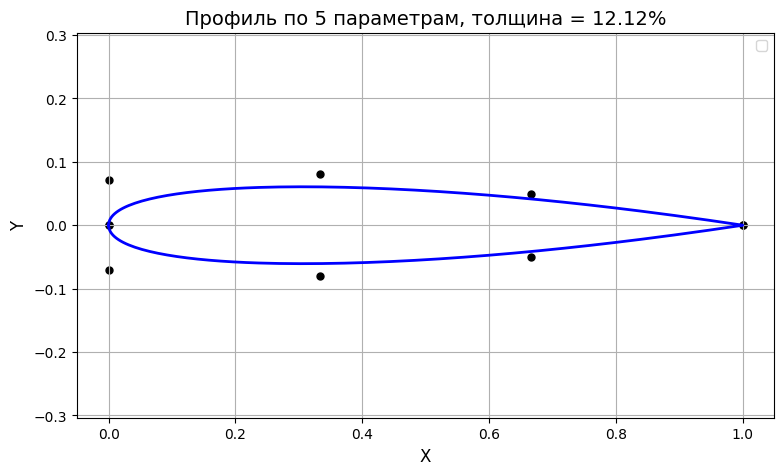

False


In [17]:
caca0012 = airfoil_structured(0.02, [0.08, 0.05], [-0.08, -0.05], 10**-4)
caca0012.plot()
caca0012.self_intersect()
print(caca0012.self_intersect())
caca0012.create_icem_file(500)
f_coords = caca0012.coords(100)
